<a href="https://colab.research.google.com/github/doyooni303/DY-s-Hustle/blob/master/%5BNLP_Study%5D%EB%84%A4%EC%9D%B4%EB%B2%84_%EC%98%81%ED%99%94_%EB%A6%AC%EB%B7%B0_%EA%B0%90%EC%84%B1_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 시작

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
!pip install konlpy
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 460kB 43.0MB/s 
     |████████████████████████████████| 92kB 12.1MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


# 데이터 로드

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f61d8c46fd0>)

In [ ]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')
print('훈련용 리뷰 개수 :',len(train_data))
print('검증용 리뷰 개수 :',len(test_data))
train_data.head(5),test_data.head(5)

훈련용 리뷰 개수 : 150000
검증용 리뷰 개수 : 50000


(         id                                           document  label
 0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
 1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
 2  10265843                                  너무재밓었다그래서보는것을추천한다      0
 3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
 4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1,
         id                                           document  label
 0  6270596                                                굳 ㅋ      1
 1  9274899                               GDNTOPCLASSINTHECLUB      0
 2  8544678             뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0
 3  6825595                   지루하지는 않은데 완전 막장임... 돈주고 보기에는....      0
 4  6723715  3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??      0)

# 중복 및 공백 확인

In [ ]:
print(train_data['document'].nunique(), train_data['label'].nunique())
print(len(train_data)) #3818 개가 중복 됨

146182 2
150000


In [ ]:
print(test_data['document'].nunique(), test_data['label'].nunique())
print(len(test_data)) # 843개가 중복 됨

49157 2
50000


In [ ]:
# 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
print('총 샘플의 수 :',len(train_data))
train_data


총 샘플의 수 : 146183


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


   label  count
0      0  73342
1      1  72841


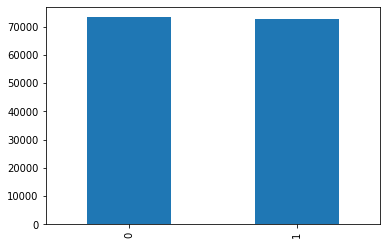

In [ ]:
train_data['label'].value_counts().plot(kind = 'bar')
#train_data['label'].value_counts() # 엇비슷
print(train_data.groupby('label').size().reset_index(name = 'count'))

In [ ]:
null_check=train_data.isnull().values.any()
print(null_check)
if null_check:
  print(train_data.isnull().sum())
  print(train_data.loc[train_data.document.isnull()])


True
id          0
document    1
label       0
dtype: int64
            id document  label
25857  2172111      NaN      1


In [ ]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


# Cleaning

In [ ]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
len(train_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


146182

In [ ]:
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    391
label         0
dtype: int64


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
584,7117896,NaN,0
593,6478189,NaN,0
638,9364602,NaN,0
668,1600635,NaN,0
1559,6918082,NaN,1


In [ ]:
train_data = train_data.dropna(how = 'any')
print(len(train_data)) #146182-391=145791

145791


In [ ]:
#test data 정리
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48995


# 토큰화

In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','에게','에서']

In [ ]:
X_train = []
okt=Okt()
for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [ ]:
print(X_train[:5])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다'], ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정'], ['사이', '몬페', '그', '익살스럽다', '연기', '돋보이다', '영화', '스파이더맨', '늙다', '보이다', '커스틴', '던스트', '너무나도', '이쁘다', '보이다']]


In [ ]:
X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

# 정수 인코딩

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
print(tokenizer.word_index)
print(len(tokenizer.word_index))

{'영화': 1, '보다': 2, '을': 3, '없다': 4, '이다': 5, '있다': 6, '좋다': 7, '너무': 8, '다': 9, '정말': 10, '되다': 11, '재밌다': 12, '적': 13, '만': 14, '같다': 15, '진짜': 16, '로': 17, '아니다': 18, '않다': 19, '점': 20, '만들다': 21, '나오다': 22, '연기': 23, '것': 24, '평점': 25, '내': 26, '최고': 27, '그': 28, '나': 29, '안': 30, '인': 31, '스토리': 32, '생각': 33, '못': 34, '왜': 35, '드라마': 36, '게': 37, '감동': 38, '사람': 39, '보고': 40, '이렇다': 41, '말': 42, '고': 43, '아깝다': 44, '더': 45, '배우': 46, '때': 47, 'ㅋㅋ': 48, '아': 49, '감독': 50, '거': 51, '그냥': 52, '재미있다': 53, '요': 54, '재미': 55, '시간': 56, '내용': 57, '뭐': 58, '까지': 59, '중': 60, '주다': 61, '자다': 62, '하고': 63, '지루하다': 64, '재미없다': 65, '쓰레기': 66, '수': 67, '네': 68, '모르다': 69, '가다': 70, '들다': 71, '그렇다': 72, '싶다': 73, '지': 74, '작품': 75, '사랑': 76, '알다': 77, '하나': 78, '다시': 79, '마지막': 80, '볼': 81, '이건': 82, '정도': 83, '저': 84, '완전': 85, '오다': 86, 'ㅋ': 87, 'ㅠㅠ': 88, '많다': 89, '처음': 90, 'ㅋㅋㅋ': 91, '장면': 92, '액션': 93, '주인공': 94, '이렇게': 95, '안되다': 96, '걸': 97, '차다': 98, '나다': 99, '개': 100, '하': 101, '최악': 1

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43750
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.627428571428574
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8816737945998678


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19415


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:3])

[[50, 453, 17, 259, 658], [932, 456, 41, 601, 2, 213, 1448, 24, 960, 674, 20], [385, 2443, 1, 2314, 5670, 3, 221, 10]]


In [ ]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [ ]:
# 저빈도 단어 제거 후 생긴 공백 제거
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
#공백 index 리스트

In [ ]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145379
145379


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


# 패딩

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.943286169254156


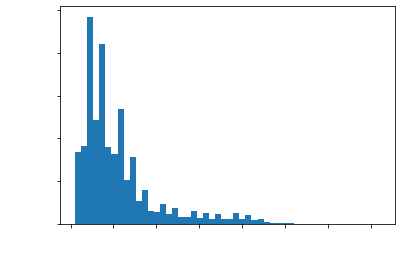

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
# map(len,X_train)= X_train 안에 있는 단어시퀀스 리스트의 길이를 구함
plt.hist([len(s) for s in X_train], bins=50)
plt.xticks(color='white')
plt.yticks(color='white')
plt.xlabel('length of samples',color='white')
plt.ylabel('number of samples',color='white')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))
max_len=30
below_threshold_len(30,X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.16628261303215


In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)


# LSTM

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1939/1939 [==============================] - 161s 82ms/step - loss: 0.4394 - acc: 0.7903 - val_loss: 0.3442 - val_acc: 0.8494

Epoch 00001: val_acc improved from -inf to 0.84939, saving model to best_model.h5
Epoch 2/15
1939/1939 [==============================] - 158s 81ms/step - loss: 0.2925 - acc: 0.8758 - val_loss: 0.3379 - val_acc: 0.8548

Epoch 00002: val_acc improved from 0.84939 to 0.85479, saving model to best_model.h5
Epoch 3/15
1939/1939 [==============================] - 158s 81ms/step - loss: 0.2396 - acc: 0.9002 - val_loss: 0.3602 - val_acc: 0.8512

Epoch 00003: val_acc did not improve from 0.85479
Epoch 4/15
1939/1939 [==============================] - 159s 82ms/step - loss: 0.1965 - acc: 0.9209 - val_loss: 0.3843 - val_acc: 0.8500

Epoch 00004: val_acc did not improve from 0.85479
Epoch 5/15
1939/1939 [==============================] - 158s 82ms/step - loss: 0.1578 - acc: 0.9370 - val_loss: 0.4645 - val_acc: 0.8421

Epoch 00005: val_acc did not improve from 0

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1532/1532 [==============================] - 14s 9ms/step - loss: 0.3485 - acc: 0.8476

 테스트 정확도: 0.8476


# 리뷰 예측하기

In [ ]:
def sentiment_predict(new_sentence):#new sentence는 '~~'으로 된 문자열
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print(f'{new_sentence}:')
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print(f'{new_sentence}:')
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [ ]:
comments=['ㅋㅋㅋ완전웃김','존노잼','하.. 내 시간 ㅠㅠ','시간만 날림. 제발 보지 마셈','그냥..그럼']

for comment in comments:
  sentiment_predict(comment)

['ㅋㅋㅋ', '완전', '웃기다']:
86.72% 확률로 긍정 리뷰입니다.

['존', '노잼']:
99.90% 확률로 부정 리뷰입니다.

['하', '..', '내', '시간', 'ㅠㅠ']:
53.20% 확률로 긍정 리뷰입니다.

['시간', '만', '날림', '.', '제발', '보지', '마셈']:
96.85% 확률로 부정 리뷰입니다.

['그냥', '..', '그렇다']:
90.55% 확률로 부정 리뷰입니다.

